## Load the paramaters and imports and set some variables


In [2]:
from fuzzywuzzy import fuzz
from loguru import logger
import pandas as pd
import pyodbc

global MSSQL_SERVER
global DATABASE_NAME
MSSQL_SERVER = "STRDVPDBSQL01"
DATABASE_NAME = "masterdata_steam"
conn = pyodbc.connect(
    "DRIVER={SQL Server};SERVER="
    + MSSQL_SERVER
    + ";DATABASE="
    + DATABASE_NAME
    + ";Trusted_Connection=yes",
    timeout=15,
)
print(f"Connected to SQL Server {MSSQL_SERVER} and table {DATABASE_NAME}")
print(f"using pandas version {pd.__version__}")

Connected to SQL Server STRDVPDBSQL01 and table masterdata_steam
using pandas version 2.1.1


### Querry used to get the data


In [3]:
def load_components_from_sql() -> pd.DataFrame:
    cursor = conn.cursor()
    query = """
    SELECT DISTINCT
	comp.[Server]
    ,comp.[internal_article_number]
    ,comp.[article_hash]
    ,comp.[componentname]
    ,comp.[componentidentifier]
    ,comp.[manufacturer]
    ,comp.[manufacturer_description]
    ,comp.[component_erpreferencenumber]
    ,comp.[implant]
    FROM [masterdata_steam].[dbo].[Components] comp
	JOIN dbo.TPI_content tpic ON tpic.article_hash = comp.article_hash
	JOIN dbo.TPI tp ON tp.tpi_hash = tpic.tpi_hash AND tp.deleted = 0
    order by comp.[Server]
    """
    with conn:
        cursor.execute(query)
        query_result = [
            dict(line)
            for line in [
                zip([column[0] for column in cursor.description], row)
                for row in cursor.fetchall()
            ]
        ]
        df = query_result

    return df

In [4]:
def load_component_packingnotes_from_sql() -> pd.DataFrame:
    cursor = conn.cursor()
    query = """
    --begin-sql
    SELECT article_hash,
    packingnote
    FROM [masterdata_steam].[dbo].[Component_packingnote]
    --end-sql
    """
    with conn:
        cursor.execute(query)
        query_result = [
            dict(line)
            for line in [
                zip([column[0] for column in cursor.description], row)
                for row in cursor.fetchall()
            ]
        ]
        df = query_result
    return df

In [5]:
def load_component_process_instructions_from_sql() -> pd.DataFrame:
    cursor = conn.cursor()
    query = """
    --begin-sql
    SELECT compi.article_hash,
    compi.instruction_code,
    proci.Language,
    proci.Description FROM dbo.component_process_instructions compi
    LEFT JOIN dbo.ProcessInstructions_Desc proci ON compi.instruction_code = proci.Code
    --end-sql
    """
    with conn:
        cursor.execute(query)
        query_result = [
            dict(line)
            for line in [
                zip([column[0] for column in cursor.description], row)
                for row in cursor.fetchall()
            ]
        ]
        df = query_result
    return df

In [6]:
def load_component_assembly_from_sql() -> pd.DataFrame:
    cursor = conn.cursor()
    query = """
    --begin-sql
        SELECT	server,
        customertoken,
        tpi_objectno,
        tpi_revision,
        compound_article_hash,
        article_hash,
        position,
        pieces,
        quantity FROM dbo.component_assembly
    --end-sql
    """
    with conn:
        cursor.execute(query)
        query_result = [
            dict(line)
            for line in [
                zip([column[0] for column in cursor.description], row)
                for row in cursor.fetchall()
            ]
        ]
        df = query_result
    return df

In [7]:
def load_component_tpi_content_from_sql() -> pd.DataFrame:
    cursor = conn.cursor()
    query = """
    --begin-sql
    SELECT t.Server,
    t.Customertoken,
    t.tpi_erpreferencenumber,
    tra.trayname,
    tcon.article_hash,
    tcon.quantity
    FROM tpi t
    LEFT JOIN dbo.TPI_content tcon ON tcon.tpi_hash = t.tpi_hash
    LEFT JOIN dbo.traylist tra ON tra.tpi_objectno = t.tpi_Objectno
    WHERE tcon.workplan = 0 AND t.deleted = 0
    ORDER BY t.Server, t.tpi_erpreferencenumber,tra.trayname
    --end-sql
    """
    with conn:
        cursor.execute(query)
        query_result = [
            dict(line)
            for line in [
                zip([column[0] for column in cursor.description], row)
                for row in cursor.fetchall()
            ]
        ]
        df = query_result
    return df

### components/packingnotes/processinstructions

In [8]:
_components_df = pd.DataFrame(load_components_from_sql())
print(f"{len(_components_df)} components loaded")

74343 components loaded


In [9]:
_comp_process_instructions_df = pd.DataFrame(load_component_process_instructions_from_sql())
print(f"{len(_comp_process_instructions_df)} component process instructions loaded")

28516 component process instructions loaded


In [10]:
_components_packingnotes_df = pd.DataFrame(load_component_packingnotes_from_sql())
print(f"{len(_components_packingnotes_df)} components packingnotes loaded")

12397 components packingnotes loaded


In [11]:
_components_assembly_df = pd.DataFrame(load_component_assembly_from_sql())
print(f"{len(_components_assembly_df)} components assembly loaded")

23984 components assembly loaded


In [8]:
_components_tpi_content_df = pd.DataFrame(load_component_tpi_content_from_sql())
print(f"{len(_components_tpi_content_df)} components tpi content loaded")

292282 components tpi content loaded


## Manufacturers

- create dataframe from the grouped manufacturers
- create a csv document with the data


In [13]:
manufacturers = (
    _components_df.groupby(["manufacturer_description"])["manufacturer_description"]
    .count()
    .sort_values(ascending=False)
)
manufacturers.explode().to_csv(
    "output/manufacturer_count.csv",
    sep=";",
    index_label=["manufacturer_description", "count"],
    encoding="utf-8",
)

679 manufacturers with less than 10 components


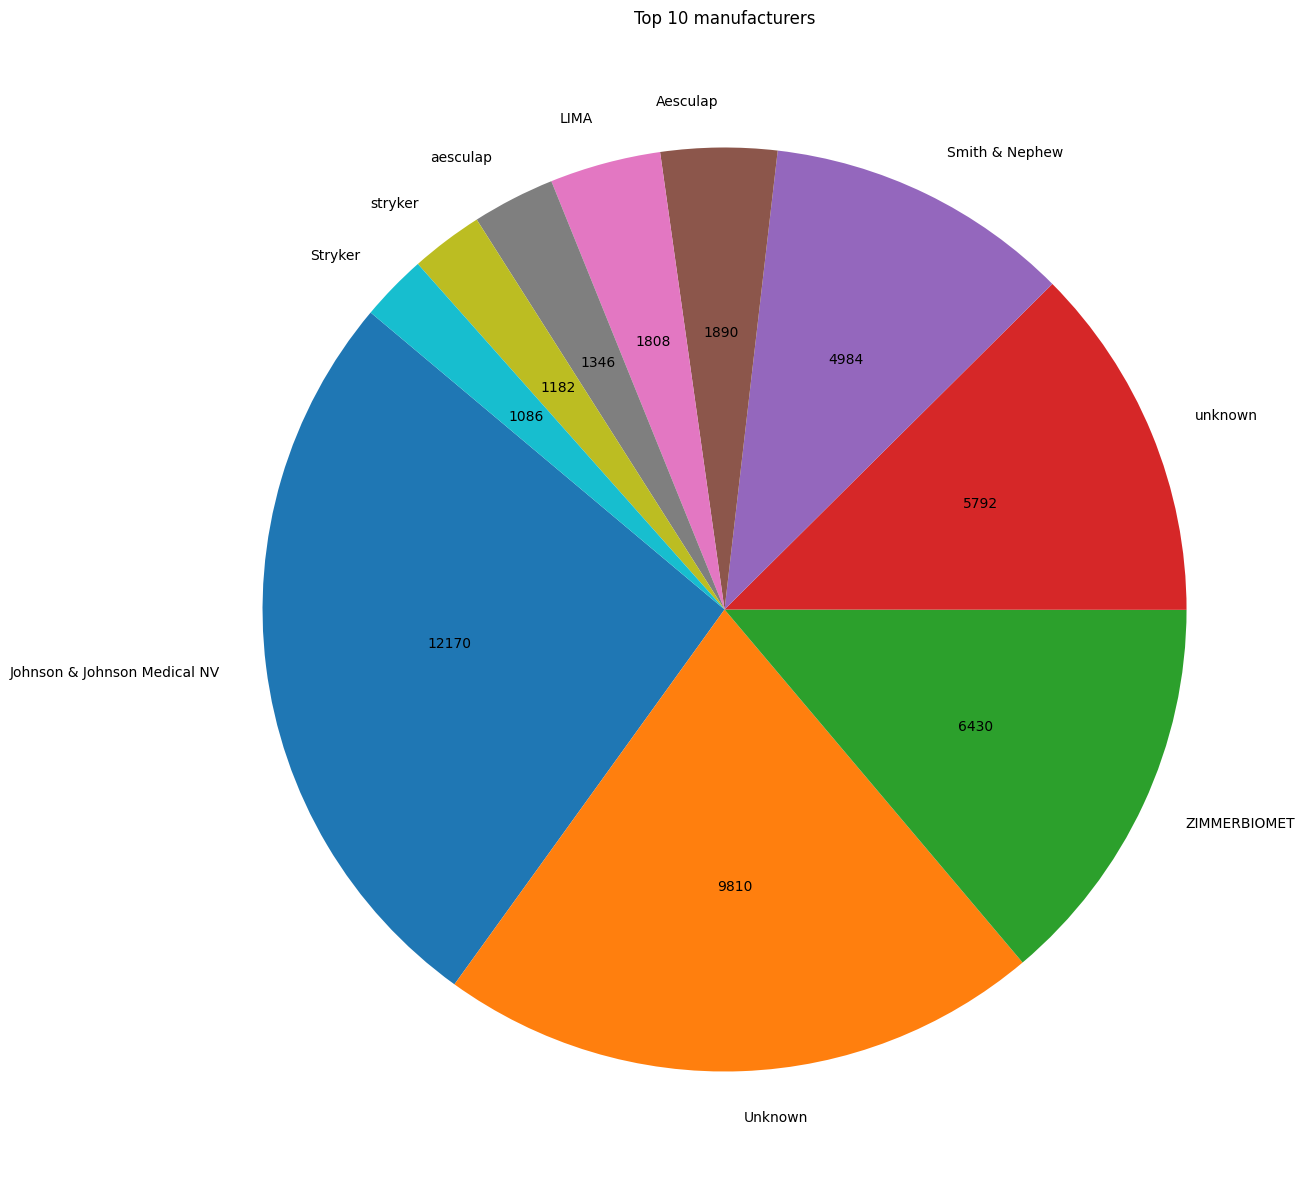

In [14]:
from matplotlib import pyplot as plt


_df_manufacturer_count = manufacturers.sort_values(ascending=False).explode().to_frame()

_manufacturers_with_low_component_count = _df_manufacturer_count.where(_df_manufacturer_count < 10).dropna()
_manufacturers_with_low_component_count.to_csv("output/manufacturer_with_low_component_count.csv",
    sep=";",
    index_label=["manufacturer_description", "count"],
    encoding="utf-8",
)
print(f"{len(_manufacturers_with_low_component_count)} manufacturers with less than 10 components")

# show the top 10 manufacturers with count in a pie chart and also show the count
plt.figure(figsize=(15, 15))
plt.pie(
manufacturers[:10],
    labels=manufacturers[:10].index,
    # show the count, not the percentage
    autopct=lambda p: "{:.0f}".format(p * sum(manufacturers[:10]) / 100),
    startangle=140,
)
plt.title("Top 10 manufacturers")
plt.show()

## find similar manufacturers


In [15]:
from collections import deque
from functools import lru_cache


@lru_cache()
def process_manufacturers():
    _similar_manufacturers = {}
    _count = len(manufacturers)

    print(f"{_count} manufacturers to check")
    _ratio: int = 85
    _queue_one = deque(manufacturers.keys())

    # compare all manufacturers with each other and pop them from the queue if they are similar
    for _ in range(_count):
        _queue_len = len(_queue_one)
        if _queue_len == 0:
            break
        _manufacturer_one = _queue_one.popleft()

        for _manufacturer_two in _queue_one:
            _similarity = fuzz.WRatio(_manufacturer_one, _manufacturer_two)
            if _similarity >= _ratio:
                if _manufacturer_one not in _similar_manufacturers:
                    _similar_manufacturers[_manufacturer_one] = []
                    # print(f"L1: create {_manufacturer_one}",end="\r")
                if _manufacturer_two not in _similar_manufacturers[_manufacturer_one]:
                    _similar_manufacturers[_manufacturer_one].append(_manufacturer_two)
                    # print(f"L2: {_manufacturer_one} and {_manufacturer_two} are similar with {_similarity}% queue len: {_queue_len}",end="\r")
                _queue_one.remove((_manufacturer_two))
                break

    df_similar_manufacturers = pd.DataFrame.from_dict(
        _similar_manufacturers, orient="index"
    )
    df_similar_manufacturers.to_csv(
        f"output/similar_manufacturers_with{_ratio}_ratio.csv",
        sep=";",
        encoding="utf-8",
        index_label=["manufacturer_description", "similar_manufacturer_description"],
    )
    print(
        f"{len(df_similar_manufacturers)} similar manufacturers found with {_ratio}% similarity"
    )
process_manufacturers()

991 manufacturers to check
289 similar manufacturers found with 85% similarity


In [16]:
# output all the manufacturers
manufacturers.to_csv(
    "output/manufacturers.csv",
    sep=";",
    encoding="utf-8",
    index_label=["manufacturer_description"],
)


In [17]:
# Assuming you want to create a pie chart based on the 'column_name' column of the DataFrame
wedge_sizes = _manufacturers_with_low_component_count["manufacturer_description"].values

# Sort the data by the values in ascending order
sorted_data = _manufacturers_with_low_component_count.sort_values(ascending=True)

# Select the lowest 10 values
lowest_10 = sorted_data.head(10)

# Create a pie chart for the lowest 10 values
plt.figure(figsize=(15, 15))
plt.pie(
    lowest_10,
    labels=lowest_10.index,
    autopct=lambda p: "{:.0f}".format(p * lowest_10.sum() / 100),
    startangle=140,
)
plt.title("Manufacturers with the lowest 10 components")
plt.show()


TypeError: DataFrame.sort_values() missing 1 required positional argument: 'by'

### Components Analyse

In [9]:
_components_df.query("componentidentifier.str.startswith('GR')").to_csv("output/components_with_gr.csv", sep=";", encoding="utf-8")
_components_df.query("componentidentifier.str.startswith('IR')").to_csv("output/components_with_ir.csv", sep=";", encoding="utf-8")

_unique_componentidentifiers = _components_df.groupby(["componentidentifier"])["componentidentifier"].count()
_unique_componentidentifiers_dict = (_unique_componentidentifiers.sort_values(ascending=False).explode().to_dict())
_unique_componentidentifiers_df = pd.DataFrame.from_dict(_unique_componentidentifiers_dict, orient="index", columns=["componentidentifier"])

_unique_componentidentifiers_df.to_csv(
    "output/componentidentifier_count.csv",
    sep=";",
    index_label=["componentidentifier", "count"],
    encoding="utf-8",
)

print(f"{len(_unique_componentidentifiers)} unique componentidentifiers found")


NameError: name '_components_df' is not defined

In [ ]:
# filter the componentidentifiers
_filterd_component_identifiers = _components_df.copy()

_filterd_component_identifiers = _filterd_component_identifiers[
    ~(_filterd_component_identifiers["componentidentifier"].str.startswith("GR"))
    & ~(_filterd_component_identifiers["componentidentifier"].str.startswith("IR"))
    # & ~(_filterd_component_identifiers['componentidentifier'].str.startswith('Unk'))
    # & ~(_filterd_component_identifiers['componentidentifier'].str.startswith('unknown'))
    # & ~(_filterd_component_identifiers['componentidentifier'].str.startswith('Unknown'))
    # & ~(_filterd_component_identifiers['componentidentifier'].str.startswith('unk'))
]
_filterd_component_identifiers.to_csv("output/components_without_gr_ir.csv",sep=";",index_label=["componentidentifier", "count"],encoding="utf-8")

_filterd_component_identifiers.drop(columns=["manufacturer"], inplace=True)
_filterd_component_identifiers.drop(columns=["implant"], inplace=True)
_filterd_component_identifiers.drop(columns=["component_erpreferencenumber"], inplace=True)

print(f"{len(_filterd_component_identifiers)} components without GR and IR")

In [ ]:
duplicate_components = _components_df.groupby('componentname')['componentidentifier'].unique().reset_index()

# Filter the groups where there are multiple unique 'componentidentifier' values
duplicate_components = duplicate_components[duplicate_components['componentidentifier'].apply(len) > 1]

# Now, 'duplicate_components' contains rows where component names have different identifiers
print(f"{len(duplicate_components)} components with multiple identifiers")

duplicate_components.to_csv("output/duplicate_components.csv",sep=";",index_label=["componentname", "componentidentifier"],encoding="utf-8")

In [ ]:
# get only the unique trays per customertoken
_unique_trays_per_customertoken = _components_tpi_content_df.groupby(["Customertoken"])["trayname"].unique()
_unique_trays_per_customertoken.to_csv("output/unique_trays_per_customertoken.csv",sep=";",index_label=["Customertoken", "trayname"],encoding="utf-8")

In [ ]:
#make a piechart with the trays per customertoken
from matplotlib import pyplot as plt

data_unique = {
    'CustomerToken': _unique_trays_per_customertoken.index,
    'Trays': _unique_trays_per_customertoken.values
}
df = pd.DataFrame(data_unique)
# Calculate the tray count for each customer
df['TrayCount'] = df['Trays'].apply(len)

# Create a pie chart
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Create a subplot for the pie chart
plt.pie(df['TrayCount'], labels=df['CustomerToken'], autopct='%1.1f%%', startangle=140)
plt.title('Tray Distribution by Customer')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Create a bar chart
plt.subplot(1, 2, 2)  # Create a subplot for the bar chart
bars = plt.bar(df['CustomerToken'], df['TrayCount'])
plt.xlabel('Customer Token')
plt.ylabel('Tray Count')
plt.title('Tray Count by Customer')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add count values above the bars
for bar, count in zip(bars, df['TrayCount']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, str(count), ha='center')

# Adjust figure size
plt.gcf().set_size_inches(16, 6)

# Adjust layout spacing
plt.tight_layout()

# Show both charts
plt.show()

In [ ]:
# count the unique componentidentifiers per customertoken
_unique_componentidentifiers_per_customertoken_count = _components_tpi_content_df.groupby(["Customertoken"])["article_hash"].nunique()
# count the number of components per customertoken
# _components_per_customertoken_count = _components_tpi_content_df.groupby(["Customertoken"])["article_hash"].count()

# we need the sum of the quantity per customertoken
_components_per_customertoken_count = _components_tpi_content_df.groupby(["Customertoken"])["quantity"].sum()

# make a piechart with the unique componentidentifiers per customertoken
from matplotlib import pyplot as plt

data_unique = {
    'CustomerToken': _unique_componentidentifiers_per_customertoken_count.index,
    'UniqueComponentIdentifiers': _unique_componentidentifiers_per_customertoken_count.values
}
df = pd.DataFrame(data_unique)

data_non_unique = {
    'CustomerToken': _components_per_customertoken_count.index,
    'ComponentIdentifiers': _components_per_customertoken_count.values
}
df_non_unique = pd.DataFrame(data_non_unique)

# Calculate the component identifiers count for each customer
df['ComponentIdentifiersCount'] = df_non_unique['ComponentIdentifiers']

# Calculate the unique component identifiers count for each customer
df['UniqueComponentIdentifiersCount'] = _unique_componentidentifiers_per_customertoken_count.values

# Create a bar chart with the component identifiers count
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Create a subplot for the bar chart
bars = plt.bar(df['CustomerToken'], df['ComponentIdentifiersCount'])
plt.xlabel('Customer Token')
plt.ylabel('Component Identifiers Count')
plt.title('Component Identifiers Count by Customer')

# get the total component identifiers count
total_component_identifiers_count = df['ComponentIdentifiersCount'].sum()
# put the number in the component identifiers count bar chart on the top right
plt.text(0.95, 0.95, f"Total: {total_component_identifiers_count}", ha='right', va='top', transform=plt.gca().transAxes)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add count values above the bars
for bar, count in zip(bars, df['ComponentIdentifiersCount']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, str(count), ha='center')

# Create a bar chart with the unique component identifiers count
plt.subplot(1, 2, 2)  # Create a subplot for the bar chart
bars = plt.bar(df['CustomerToken'], df['UniqueComponentIdentifiersCount'])
plt.xlabel('Customer Token')
plt.ylabel('Unique Component Identifiers Count')
plt.title('Unique Component Identifiers Count by Customer')

# get the total unique component identifiers count
total_unique_component_identifiers_count = df['UniqueComponentIdentifiersCount'].sum()
# put the number in the unique component identifiers count bar chart on the top right
plt.text(0.95, 0.95, f"Total: {total_unique_component_identifiers_count}", ha='right', va='top', transform=plt.gca().transAxes)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add count values above the bars
for bar, count in zip(bars, df['UniqueComponentIdentifiersCount']):

    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, str(count), ha='center')

# Adjust figure size
plt.gcf().set_size_inches(16, 6)

# Adjust layout spacing
plt.tight_layout()

# Show both charts
plt.show()


In [ ]:
# how many unique assmbly components are there per customertoken
_unique_assembly_components = _components_assembly_df.groupby(["customertoken"])["compound_article_hash"].nunique()
_unique_assembly_components.to_csv("output/unique_assembly_components.csv",sep=";",index_label=["customertoken", "compound_article_hash"],encoding="utf-8")

# show them in a pie chart
from matplotlib import pyplot as plt

# Create a bar chart
plt.subplot(1, 2, 2)  # Create a subplot for the bar chart
bars = plt.bar(_unique_assembly_components.index, _unique_assembly_components)
plt.xlabel('Customer Token')
plt.ylabel('Unique Assembly Components')
plt.title('Unique Assembly Components by Customer')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add count values above the bars
for bar, count in zip(bars, _unique_assembly_components):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, str(count), ha='center')

# Adjust figure size
plt.gcf().set_size_inches(30, 6)

# Adjust layout spacing
plt.tight_layout()

# Show both charts
plt.show()

In [ ]:
from matplotlib import pyplot as plt

_total_count_components = len(_components_df)
_total_count_unique_components = len(_unique_componentidentifiers)
_total_count_componts_with_gr = len(_components_df.query("componentidentifier.str.startswith('GR')"))
_total_count_componts_with_ir = len(_components_df.query("componentidentifier.str.startswith('IR')"))


_plt_df = pd.DataFrame(
    {
        "Total Components": [_total_count_components],
        "Unique Components": [_total_count_unique_components],
        "Components starting with GR": [_total_count_componts_with_gr],
        "Components starting with IR": [_total_count_componts_with_ir],
    }
)

_plt_df.plot(
    kind="bar",
    stacked=False,
    figsize=(8, 6),
    legend=True,
    fontsize=14,
    title="Total Components",
    edgecolor="black",
    linewidth=1,
)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=14)
plt.text(
    -0.21,
    0.0,
    f"{_total_count_components}",
    fontsize=14,
    color="black",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.1"),
)
plt.text(
    -0.10,
    0.0,
    f"{_total_count_unique_components}",
    fontsize=14,
    color="black",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.1"),
)
plt.text(
    0.04,
    0.0,
    f"{_total_count_componts_with_gr}",
    fontsize=14,
    color="black",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.1"),
)
plt.text(
    0.15,
    0.0,
    f"{_total_count_componts_with_ir}",
    fontsize=14,
    color="black",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.1"),
)
plt.savefig("total_components.png", bbox_inches="tight")
plt.show()

In [23]:

from os import sep
from lingua import Language, LanguageDetectorBuilder
from nltk.tag import pos_tag
from nltk.tokenize import TreebankWordTokenizer

languages = [Language.ENGLISH, Language.FRENCH, Language.DUTCH]
detector = LanguageDetectorBuilder.from_languages(*languages).build()

# get the component names
_component_names = _components_df["componentname"].to_list()
_token_dict = {}
_language_dict = {}

tokenizer = TreebankWordTokenizer()

for comp in _component_names:

    lang = detector.detect_language_of(comp)

    if lang not in _language_dict:
        _language_dict[lang] = 1
    else:
        _language_dict[lang] += 1

    pos = pos_tag(tokenizer.tokenize(comp))

    for token in pos:
        if token[0] not in _token_dict:
            # encapsulate the token in double quotes to prevent the csv from splitting the token
            _token_dict[token[0]] = 1
        else:
            _token_dict[token[0]] += 1

# sort the dictionary by value
_token_dict = dict(sorted(_token_dict.items(), key=lambda item: item[1], reverse=True))

#save the dictionary to a csv file
with open('output/token_dict.csv', 'w', encoding="utf-8") as f:
    for key in _token_dict.keys():
        f.write(f'"{key}";"{_token_dict[key]}"\n')
with open('output/language_dict.csv', 'w', encoding="utf-8") as f:
    for key in _language_dict.keys():
        f.write(f'"{key}";"{_language_dict[key]}"\n')


In [ ]:
import nltk
_measurement_dict = {}

for comp in _component_names[:10]:
    data = nltk.regexp_tokenize(comp, r'(?:(⌀)\s*)?(\d+(\.\d+)?)\s*(m|M|cm|CM|mm|MM)')
    if len(data) > 0:
        if data[0] not in _measurement_dict:
            _measurement_dict[data[0]] = 1
            print(f"{comp} has a measurement of {data[0]}")
        else:
            _measurement_dict[data[0]] += 1
            print(f"{comp} has a measurement of {data[0]}")

print(f"measurement dict: {_measurement_dict}")

In [ ]:
from sklearn.cluster import KMeans

# Load spaCy models
nlp_en = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner'])
nlp_fr = spacy.load('fr_core_news_sm', disable=['parser', 'tagger', 'ner'])
nlp_nl = spacy.load('nl_core_news_sm', disable=['parser', 'tagger', 'ner'])

# Load your CSV
tokens_df = _token_dict

# Function to get the average vector representation for a token
def get_avg_vector(token):
    vec_en = nlp_en(token).vector
    vec_fr = nlp_fr(token).vector
    vec_nl = nlp_nl(token).vector
    return (vec_en + vec_fr + vec_nl) / 3

# Get the average vectors for all tokens
tokens_df['Vector'] = tokens_df['Token'].apply(get_avg_vector)

# Convert the vectors into a matrix for clustering
vectors = tokens_df['Vector'].tolist()

# Cluster tokens using KMeans
num_clusters = 10  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
tokens_df['Cluster'] = kmeans.fit_predict(vectors)

# Display the tokens in each cluster
clustered_tokens = tokens_df.groupby('Cluster')['Token'].apply(list)
print(clustered_tokens)